In [1]:
from pathlib import Path
from fastai.conv_learner import *
from fastai.dataset import *
import matplotlib.patches as patches

Change to wherever the following files are.

In [2]:
PATH = Path('../data/pascal')

In [3]:
pred_bb = V(np.load(PATH/'pred_bb.npy'))
pred_cls = V(np.load(PATH/'pred_cls.npy'))
targ_bb = V(np.load(PATH/'targ_bb.npy'))
targ_cls = V(np.load(PATH/'targ_cls.npy'))
overlaps0 = np.load(PATH/'overlaps0.npy')
overlaps4 = np.load(PATH/'overlaps4.npy')
size = 224
nb_classes = 20

pred_bb,pred_cls contains the predictions for a mini-batch, given by the first model with 16 anchors. targ_bb, targ_cls contain the associated target of the mini-batch.

**Goal: Completely rewrite the loss function.** 
- Final loss for the minibatch 15.6527
- Idx 0 of our minibatch:
  - ground truth classes to find: [20,20,20,20,20,20,20,20,14,20,1,20,20,20,14,20]
  - cls loss 0.3888
  - bb loss 0.1656
- Idx 4 of our minibatch:
  - ground truth classes to find: [20,14,14,20,20,20,4,20,20,20,14,20,20,20,14,4]
  - cls loss 0.7884
  - bb loss 0.1239

**Plan:**
1. Define the anchors (the 4 by 4 grid to begin with)
2. Define the functions to compute the overlaps between our ground truth objects and the anchors
3. Attribute a ground truth object to each anchor
4. Compute the loss for the predicted classes
5. Compute the loss for the predicted bboxes
6. Sum over the minibatch
    

# Define the anchors

For the anchors then the predicted bboxes, coordinates vary between 0 and 1. We'll scale the target bboxes accordingly later.

First let's get the centers of our anchors.

In [4]:
def get_anc_ctrs(n_split):
    offset = 1/(2*n_split)
    x_coords = np.array([offset + i/n_split for i in range(n_split)] * n_split)
    y_coords = np.concatenate([[offset + i/n_split] * n_split for i in range(n_split)])
    return np.array([x_coords,y_coords]).transpose()

In [5]:
n_split = 4
anc_ctrs = get_anc_ctrs(n_split); anc_ctrs

array([[0.125, 0.125],
       [0.375, 0.125],
       [0.625, 0.125],
       [0.875, 0.125],
       [0.125, 0.375],
       [0.375, 0.375],
       [0.625, 0.375],
       [0.875, 0.375],
       [0.125, 0.625],
       [0.375, 0.625],
       [0.625, 0.625],
       [0.875, 0.625],
       [0.125, 0.875],
       [0.375, 0.875],
       [0.625, 0.875],
       [0.875, 0.875]])

(0, 1)

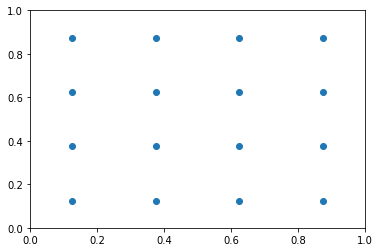

In [6]:
plt.scatter(anc_ctrs[:,0],anc_ctrs[:,1])
plt.xlim(xmin=0,xmax=1)
plt.ylim(ymin=0,ymax=1)

Loooking good. All the anchors will have the same height and width here, let's write a function to transform change center/size into top-left corner/bottom-right corner.

In [7]:
anc_ctrs = V(anc_ctrs, requires_grad=False)

In [8]:
def cs_to_crnrs(ctr,sz):
    return torch.cat([ctr-sz/2,ctr+sz/2], dim=1)

In [9]:
anc_sz = V(np.array([[1/n_split,1/n_split]] * (n_split**2)), requires_grad=False)
anc_crnrs = cs_to_crnrs(anc_ctrs,anc_sz)

In [10]:
anc_crnrs

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.2500  0.0000  0.5000  0.2500
 0.5000  0.0000  0.7500  0.2500
 0.7500  0.0000  1.0000  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.2500  0.2500  0.5000  0.5000
 0.5000  0.2500  0.7500  0.5000
 0.7500  0.2500  1.0000  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.2500  0.5000  0.5000  0.7500
 0.5000  0.5000  0.7500  0.7500
 0.7500  0.5000  1.0000  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

Now we have our 16 anchors!

# Define the function to compute the overlap

**Goal:** Write a function taking two arrays bb1 and bb2 representing bboxes of size n x 4 and p x 4 respectively, returning an array of siz n x p containing in coordinate (i,j) the jaccard index (or IoU) of the i-th bbox in bb1 and the j-th bbox in bb2.

**To test:** The arrays overlaps0 (resp. overlaps4) contain the intended result for anc_crnrs and bb_targ[0] (resp. bb_targ[4]) 

First, let's look at what we want.

[]

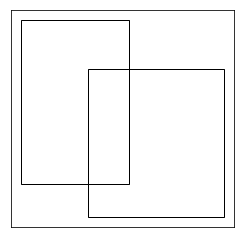

In [11]:
box1 = [0,0,10,8] ; box2 = [3,5,12,15]
fig,ax = plt.subplots(figsize=(4,4))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.invert_yaxis() #To have the top at pixel 0 like in our images.

def draw_rect(ax,box,fill=False):
    ax.add_patch(patches.Rectangle((box[1],box[0]),box[3]-box[1],box[2]-box[0],fill=fill))

draw_rect(ax,box1)
draw_rect(ax,box2)
ax.plot()

We have to compute the number of pixels in the intersection and the union of the two boxes. The intersection is a rectangle, so that'll be easy once we know its width and height. The union has the size of the first box, plus the size of the second box minus the size of the intersection (since those pixels were counted twice).

Top-left corner of our intersection has the maximum coordinates between the two top-left corners, bottom-right corner the minimum coordinates between the two bottom-right corners.

[]

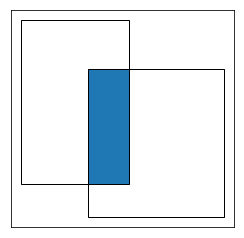

In [12]:
box_inter = np.concatenate([np.maximum(box1[:2],box2[:2]), np.minimum(box1[2:],box2[2:])])

fig,ax = plt.subplots(figsize=(4,4))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.invert_yaxis() #To have the top at pixel 0 like our images.
draw_rect(ax,box_inter,fill=True)
draw_rect(ax,box1)
draw_rect(ax,box2)
ax.plot()

Now let's do the same thing with tensors of boxes. We'll have to add dimensions since we want the final result to be of size n x p. To do that, we transform box1 in a tensor of size n x 1 x 4, box 2 in a tensor of size 1 x p x 4 so that what we did for two boxes will easily be broadcasted to the tensors.

In [13]:
def intersection(box1,box2):
    inter_top_crnrs = torch.max(box1[:,None,:2], box2[None,:,:2])
    inter_btm_crnrs = torch.min(box1[:,None,2:], box2[None,:,2:])
    inter_sizes = torch.clamp(inter_btm_crnrs - inter_top_crnrs,min=0) #In case two boxes don't overlap.
    return inter_sizes[:,:,0] * inter_sizes[:,:,1] 

In [14]:
intersection(anc_crnrs*224,targ_bb[0].view(-1,4))

Variable containing:

Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0   392
    0     0     0     0     0     0     0     0     0     0     0   189   392
    0     0     0     0     0     0     0     0     0     0     0   504   392
    0     0     0     0     0     0     0     0     0     0     0   495   266
    0     0     0     0     0     0     0     0     0     0     0     0  3136
    0     0     0     0     0     0     0     0     0     0     0  1176  3136
    0     0     0     0     0     0     0     0     0     0     0  3136  3136
    0     0     0     0     0     0     0     0     0     0     0  3080  2128
    0     0     0     0     0     0     0     0     0     0     0     0  3136
    0     0     0     0     0     0     0     0     0     0     0  1176  3136
    0     0     0     0     0     0     0     0     0     0     0  3136  3136
    0     0     0     0     0     0     0     0     0     0     0  3080  2128
    0     0     0     0  

Let's get the sizes of one array of bboxes.

In [15]:
def get_sizes(bb):
    return (bb[:,2] - bb[:,0]) * (bb[:,3] - bb[:,1])

Then there's just to compute the union with the formula above and make the quotient. Let's just remember the sizes of bb1 will be a tensor of size (n) and the sizes of bb2 a tensor of size (p) so again, we have to brodcast by adding a dimension.

In [16]:
def jaccard(bb1,bb2):
    inter = intersection(bb1,bb2)
    union = get_sizes(bb1)[:,None] + get_sizes(bb2)[None,:] - inter
    return inter / union

In [17]:
jaccard(targ_bb[0].view(-1,4)/224,anc_crnrs)

Variable containing:

Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0099  0.0267  0.0262  0.0000  0.0646  0.1932  0.1890  0.0000  0.0646
 0

This should match overlaps0

In [18]:
overlaps0

array([[0.     , 0.00985, 0.02671, 0.02622, 0.     , 0.06463, 0.19315, 0.18905, 0.     , 0.06463, 0.19315,
        0.18905, 0.     , 0.00217, 0.00582, 0.00571],
       [0.01309, 0.01309, 0.01309, 0.00885, 0.11533, 0.11533, 0.11533, 0.07546, 0.11533, 0.11533, 0.11533,
        0.07546, 0.02459, 0.02459, 0.02459, 0.01656],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.21347, 0.26519, 0.26519, 0.2246 ]], dtype=float32)

Almost! The problem is that we didn't suppress the zeros we used to pad the target to a size of 56 = 14x4. Why 14? It's the maximum of objects to detect in a single image in our sets so the fastai library padded up to this.

Let's write this function to unpad the class and the bboxes of our targets. To detect those, we must remove the lines that are filled with zeros. It's not obvious in the class tensor (since the category 0 exists) but it is in the bboxes tensor. Since a line corresponding to a box has only positive numbers, I chose to sum over the lines to pick the ones that are filled with 0. 

In [19]:
def unpad(t_cls,t_bb):
    t_bb = t_bb.view(-1,4) / size
    keep = t_bb.sum(dim=1).nonzero()[:,0]
    return t_cls[keep], t_bb[keep]

In [20]:
t_cls, t_bb = unpad(targ_cls[0],targ_bb[0])
jaccard(t_bb,anc_crnrs)

Variable containing:

Columns 0 to 9 
 0.0000  0.0099  0.0267  0.0262  0.0000  0.0646  0.1932  0.1890  0.0000  0.0646
 0.0131  0.0131  0.0131  0.0088  0.1153  0.1153  0.1153  0.0755  0.1153  0.1153
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 10 to 15 
 0.1932  0.1890  0.0000  0.0022  0.0058  0.0057
 0.1153  0.0755  0.0246  0.0246  0.0246  0.0166
 0.0000  0.0000  0.2135  0.2652  0.2652  0.2246
[torch.cuda.FloatTensor of size 3x16 (GPU 0)]

In [21]:
overlaps0

array([[0.     , 0.00985, 0.02671, 0.02622, 0.     , 0.06463, 0.19315, 0.18905, 0.     , 0.06463, 0.19315,
        0.18905, 0.     , 0.00217, 0.00582, 0.00571],
       [0.01309, 0.01309, 0.01309, 0.00885, 0.11533, 0.11533, 0.11533, 0.07546, 0.11533, 0.11533, 0.11533,
        0.07546, 0.02459, 0.02459, 0.02459, 0.01656],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.21347, 0.26519, 0.26519, 0.2246 ]], dtype=float32)

In [22]:
t_cls, t_bb = unpad(targ_cls[4],targ_bb[4])
jaccard(t_bb,anc_crnrs)

Variable containing:

Columns 0 to 9 
 0.2042  0.3218  0.1917  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0257  0.2124  0.2124  0.2033  0.0119  0.0896  0.0896  0.0861  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.1507  0.2558  0.2558  0.2444  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0210  0.0305  0.0305  0.0294  0.1305  0.1987
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0865  0.0414  0.0000  0.0000

Columns 10 to 15 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.1987  0.1902  0.0232  0.0337  0.0337  0.0324
 0.0000  0.0000  0.1934  0.2526  0.2526  0.2414
 0.0000  0.0481  0.0000  0.0000  0.0000  0.0583
 0.0414  0.0203  0.0000  0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 7x16 (GPU 0)]

In [23]:
overlaps4

array([[0.20419, 0.32184, 0.19171, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.02567, 0.21238, 0.21238, 0.20326, 0.01189, 0.08959, 0.08959, 0.08612, 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.15067, 0.25579, 0.25579, 0.24442, 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.02105, 0.0305 , 0.0305 , 0.02938, 0.13049, 0.19867, 0.19867,
        0.19022, 0.0232 , 0.03365, 0.03365, 0.03241],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.19336, 0.25257, 0.25257, 0.24137],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.04808, 0.     , 0.     , 0.     , 0.05825],
       [0.     , 0.     , 0.     ,

Mission accomplished!

# Attribute a ground truth object to each anchor

**Goal:** After computing the overlaps between our anchors and the ground truth bboxes, we need to decide of a mapping between each anchor and a ground truth object. The rules for this are the following:
1. For each ground truth object, attribute the anchor with the maximum overlap to it.
2. Then, to each anchor remaining, attribute the ground truth object it overlaps the most. If this maximum is less than a fixed parameter (0.4 in the notebook), attribute it to background instead.

**To test:** Compare the categories of ground truth object each anchors was given for sample 0 and 4.

Let's play with an overlaps tensor before writing the functions we need.

In [24]:
t_cls, t_bb = unpad(targ_cls[0],targ_bb[0])
overlaps = jaccard(t_bb,anc_crnrs) 

In [25]:
overlaps

Variable containing:

Columns 0 to 9 
 0.0000  0.0099  0.0267  0.0262  0.0000  0.0646  0.1932  0.1890  0.0000  0.0646
 0.0131  0.0131  0.0131  0.0088  0.1153  0.1153  0.1153  0.0755  0.1153  0.1153
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 10 to 15 
 0.1932  0.1890  0.0000  0.0022  0.0058  0.0057
 0.1153  0.0755  0.0246  0.0246  0.0246  0.0166
 0.0000  0.0000  0.2135  0.2652  0.2652  0.2246
[torch.cuda.FloatTensor of size 3x16 (GPU 0)]

In [26]:
overlaps.max(dim=1)

(Variable containing:
  0.1932
  0.1153
  0.2652
 [torch.cuda.FloatTensor of size 3 (GPU 0)], Variable containing:
  10
   8
  14
 [torch.cuda.LongTensor of size 3 (GPU 0)])

Here we see that the first ground truth object should be mapped to the 10th anchor (maximum overlap of 0.1932), the second ground truth object to the 8th anchor and the last one to the 14th anchor.

In [27]:
overlaps.max(dim=0)

(Variable containing:
  0.0131
  0.0131
  0.0267
  0.0262
  0.1153
  0.1153
  0.1932
  0.1890
  0.1153
  0.1153
  0.1932
  0.1890
  0.2135
  0.2652
  0.2652
  0.2246
 [torch.cuda.FloatTensor of size 16 (GPU 0)], Variable containing:
  1
  1
  0
  0
  1
  1
  0
  0
  1
  1
  0
  0
  2
  2
  2
  2
 [torch.cuda.LongTensor of size 16 (GPU 0)])

Then in all the remaining anchors, not one overlaps any ground truth object with more than 0.4 so they should be attributed to background.

Here is the function that takes a tensor of ground truth bboxes and returns a tensor giving, for each anchor, the number of the ground truth object it should be mapped to, -1 if it should be mapped to background.

In [30]:
def match(t_bb):
    overlaps = jaccard(t_bb,anc_crnrs)
    over_max,idx_max = overlaps.max(dim=0)
    _,forced_idx = overlaps.max(dim=1)
    over_max[forced_idx] = 1.1 #Any value greater than 1.
    for i,o in enumerate(forced_idx): 
        idx_max[o] = i
    idx_max[over_max <= 0.4] = -1
    return idx_max

In [31]:
t_cls, t_bb = unpad(targ_cls[0],targ_bb[0])
match(t_bb)

Variable containing:
-1
-1
-1
-1
-1
-1
-1
-1
 1
-1
 0
-1
-1
-1
 2
-1
[torch.cuda.LongTensor of size 16 (GPU 0)]

Looks good. Now the next step is to match the category of the ground truth object with this anchor, when it's not background. This just needs a minor tweak in the previous function.

In [32]:
def match_cat(t_c,t_bb):
    overlaps = jaccard(t_bb,anc_crnrs)
    over_max,idx_max = overlaps.max(dim=0)
    _,forced_idx = overlaps.max(dim=1)
    over_max[forced_idx] = 1.1 #Any value greater than 1.
    for i,o in enumerate(forced_idx): 
        idx_max[o] = i
    cats = t_c[idx_max]
    to_bg = over_max <= 0.4
    idx_max[to_bg] = -1
    cats[to_bg] = nb_classes
    return idx_max, cats

In [33]:
t_cls, t_bb = unpad(targ_cls[0],targ_bb[0])
match_cat(t_cls,t_bb)

(Variable containing:
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
  1
 -1
  0
 -1
 -1
 -1
  2
 -1
 [torch.cuda.LongTensor of size 16 (GPU 0)], Variable containing:
  20
  20
  20
  20
  20
  20
  20
  20
  14
  20
   1
  20
  20
  20
  14
  20
 [torch.cuda.LongTensor of size 16 (GPU 0)])

Looks good! Now ket's check the 4-th element

In [35]:
t_cls, t_bb = unpad(targ_cls[4],targ_bb[4])
match_cat(t_cls,t_bb)

(Variable containing:
 -1
  0
  1
 -1
 -1
 -1
  6
 -1
 -1
 -1
  3
 -1
 -1
 -1
  4
  5
 [torch.cuda.LongTensor of size 16 (GPU 0)], Variable containing:
  20
  14
  14
  20
  20
  20
   4
  20
  20
  20
  14
  20
  20
  20
  14
   4
 [torch.cuda.LongTensor of size 16 (GPU 0)])

This is what was expected as well. Note that here, the ground-truth object with index 2 has no anchor associated to him, which means it has already been attributed to another ground truth object. This won't happen when we have more anchors

# Compute the loss for the predicted classes

**Goal:** Write the function that computes the loss between predicted classes and their labels. This is a standard Binary Cross Entropy with one tweak: instead of being one-hot encoded, the background class correspond to a vector of 0 (which means no object was found).

**To test:** On the sample 0, we should find 0.3888, and the sample 4, 0.7884

We will need to one-hot encode our labels ourselves, since we want to treat the background as all zeros. To do this, we first create a regular one-hot encoding with the number of classes plus one, then remove the last column.

The .cpu() and .contiguous() are added to please pytorch.

In [36]:
def one_hot(labels):
    lbls = torch.eye(nb_classes+1)[labels.data.cpu()]
    return V(lbls[:,:-1].contiguous())

In [37]:
one_hot(cls)

Variable containing:

Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     1     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0  

We define the loss as a subclass of a nn.Module. It needs to store one parameter: the number of classes. When comparing to our predictions, we also have to remove the column corresponding to the background.

In [38]:
class BCELoss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    
    def forward(self, input, target):
        t_enc = one_hot(target)
        preds = input[:,:-1]
        return F.binary_cross_entropy_with_logits(preds,t_enc,size_average=False)/self.num_classes

In [39]:
cls_loss = BCELoss(nb_classes)

Let's test it on our samples.

In [40]:
t_cls, t_bb = unpad(targ_cls[0],targ_bb[0])
idx,cls = match_cat(t_cls,t_bb)
cls_loss(pred_cls[0],cls)

Variable containing:
 0.3888
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [41]:
t_cls, t_bb = unpad(targ_cls[4],targ_bb[4])
idx,cls = match_cat(t_cls,t_bb)
cls_loss(pred_cls[4],cls)

Variable containing:
 0.7884
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Looks all good!

# Compute the loss for the predicted bboxes

**Goal:** We have to compare each predicted bounding box to the one of the matching grounded object, using the L1 loss. The thing to pay attention to is that the predictions are only relative to the associated anchor.

**To test:** We should find 0.1656 for the sample 0 and 0.1239 for the sample 4.

The first thing is to convert our predictions into the real bbox. The activation for these predictions will be tanh, to have them between -1 and +1. Then the two first activations give the coordinates of the center of our bbox (to scale to the size of our anchor) relatively to the center of the anchor, the second two give the width and height, again scaled to the size of our anchor.

In [42]:
grid_size = 1/4
def activ_to_bbox(activ,anc):
    activ = F.tanh(activ)
    b_ctrs = activ[:,:2] * grid_size/2 + anc[:,:2]
    b_sizes = anc[:,2:] * (1 + activ[:,2:] /2)
    return cs_to_crnrs(b_ctrs,b_sizes)

In [43]:
anc_ctsz = torch.cat([anc_ctrs,anc_sz], dim=1)
activ_to_bbox(pred_bb[0],anc_ctsz)

Variable containing:
 0.0180  0.0281  0.3923  0.3648
 0.1880  0.0413  0.5629  0.3693
 0.4304  0.0417  0.8054  0.4166
 0.6003  0.0101  0.9752  0.3835
 0.0160  0.2210  0.3909  0.4547
 0.1213  0.2448  0.4963  0.4709
 0.3640  0.2109  0.7390  0.5858
 0.5752  0.1964  0.9501  0.5708
-0.0099  0.5182  0.3650  0.7789
 0.1210  0.5704  0.4960  0.6992
 0.3913  0.4054  0.7663  0.7738
 0.5823  0.4064  0.9570  0.7783
-0.0250  0.8021  0.3028  0.9367
 0.1607  0.8108  0.4839  0.9370
 0.3798  0.7099  0.7510  0.9536
 0.6189  0.6956  0.9639  1.0009
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

Now let's compare the predicted bboxes corresponding to ground truth objects (the one that are associated to background are discarded) and compute the loss.

In [44]:
def bb_loss(p_bb,t_c,t_bb):
    idx,cls = match_cat(t_c,t_bb)
    p_bb = activ_to_bbox(p_bb,anc_ctsz)
    keep = (idx >=0).nonzero()[:,0]
    idx[idx==-1]=0
    bbs = t_bb[idx]
    return torch.abs(p_bb[keep] - bbs[keep]).mean()

In [45]:
t_cls, t_bb = unpad(targ_cls[0],targ_bb[0])
bb_loss(pred_bb[0],t_cls,t_bb)

Variable containing:
 0.1656
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [46]:
t_cls, t_bb = unpad(targ_cls[4],targ_bb[4])
bb_loss(pred_bb[4],t_cls,t_bb)

Variable containing:
 0.1239
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Looks all good!

# Merge the results and sum over a minibatch

For the sake of efficiency, let's rewrite the function match_cat to do everything in it.

In [47]:
def loss1(p_c,p_bb,t_c,t_bb):
    t_c,t_bb = unpad(t_c,t_bb)
    p_bb = activ_to_bbox(p_bb,anc_ctsz)
    overlaps = jaccard(t_bb,anc_crnrs)
    over_max,idx_max = overlaps.max(dim=0)
    _,forced_idx = overlaps.max(dim=1)
    over_max[forced_idx] = 1.1 #Any value greater than 1.
    for i,o in enumerate(forced_idx): 
        idx_max[o] = i
    cls = t_c[idx_max]
    bbs = t_bb[idx_max]
    cls[over_max <= 0.4] = nb_classes
    cl_loss = cls_loss(p_c,cls)
    keep = (over_max >0.4).nonzero()[:,0]
    bb_loss = torch.abs(p_bb[keep] - bbs[keep]).mean()
    return cl_loss, bb_loss

In [48]:
loss1(pred_cls[0],pred_bb[0],targ_cls[0],targ_bb[0])

(Variable containing:
  0.3888
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.1656
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [49]:
loss1(pred_cls[4],pred_bb[4],targ_cls[4],targ_bb[4])

(Variable containing:
  0.7884
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.1239
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

Still looks good! Now we just have to sum over a minibatch.

In [50]:
def ssd_loss(pred_c,pred_b,targ_c,targ_b):
    l_c, l_b = 0., 0.
    for (p_c,p_b,t_c,t_b) in zip(pred_c,pred_b,targ_c,targ_b):
        l1c,l1b = loss1(p_c,p_b,t_c,t_b)
        l_c += l1c
        l_b += l1b
    return l_c + l_b

In [51]:
ssd_loss(pred_cls,pred_bb,targ_cls,targ_bb)

Variable containing:
 15.6527
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Mission accomplished!

# Let's add more anchors

**Goal:** Define all the anchors like in the second part of the notebook and check that everything runs smoothly as well.

**To test:** Use the second predicted values, the loss should be 46.0832

Let's load the second mini-batch of predicted values.

In [52]:
pred_bb1 = V(np.load(PATH/'pred_bb1.npy'))
pred_cls1 = V(np.load(PATH/'pred_cls1.npy'))

Copy the anchors augmentation parameters.

In [53]:
anc_grids = [4,2,1]
anc_zooms = [0.75, 1., 1.3]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]

Let's combine all the possible zooms and ratios

In [54]:
anc_scales = [(z*rx,z*ry) for z in anc_zooms for (rx,ry) in anc_ratios]
k = len(anc_scales)
k

9

Now we have to define the new centers and sizes of our anchors.

In [55]:
anc_ctrs = torch.cat([V(np.repeat(get_anc_ctrs(split),k,axis=0), requires_grad=False) for split in anc_grids])

In [56]:
anc_ctrs

Variable containing:
 0.1250  0.1250
 0.1250  0.1250
 0.1250  0.1250
 0.1250  0.1250
 0.1250  0.1250
 0.1250  0.1250
 0.1250  0.1250
 0.1250  0.1250
 0.1250  0.1250
 0.3750  0.1250
 0.3750  0.1250
 0.3750  0.1250
 0.3750  0.1250
 0.3750  0.1250
 0.3750  0.1250
 0.3750  0.1250
 0.3750  0.1250
 0.3750  0.1250
 0.6250  0.1250
 0.6250  0.1250
 0.6250  0.1250
 0.6250  0.1250
 0.6250  0.1250
 0.6250  0.1250
 0.6250  0.1250
 0.6250  0.1250
 0.6250  0.1250
 0.8750  0.1250
 0.8750  0.1250
 0.8750  0.1250
 0.8750  0.1250
 0.8750  0.1250
 0.8750  0.1250
 0.8750  0.1250
 0.8750  0.1250
 0.8750  0.1250
 0.1250  0.3750
 0.1250  0.3750
 0.1250  0.3750
 0.1250  0.3750
 0.1250  0.3750
 0.1250  0.3750
 0.1250  0.3750
 0.1250  0.3750
 0.1250  0.3750
 0.3750  0.3750
 0.3750  0.3750
 0.3750  0.3750
 0.3750  0.3750
 0.3750  0.3750
 0.3750  0.3750
 0.3750  0.3750
 0.3750  0.3750
 0.3750  0.3750
 0.6250  0.3750
 0.6250  0.3750
 0.6250  0.3750
 0.6250  0.3750
 0.6250  0.3750
 0.6250  0.3750
 0.6250  0.3750
 0.

In [57]:
anc_sz = np.concatenate([np.array([[scx/split,scy/split] for i in range(split*split) for (scx,scy) in anc_scales ]) 
                            for split in anc_grids])
anc_sz = V(anc_sz,requires_grad=False)

In [58]:
anc_crnrs = cs_to_crnrs(anc_ctrs,anc_sz)

On top of those, we used two more variables we have to adapt: anc_ctsz (concatenate the centers and the sizes) and grid_sizes (which was constant before but will now change).

In [59]:
anc_ctsz = torch.cat([anc_ctrs,anc_sz], dim=1)
grid_size = np.concatenate([np.array([[1/split,1/split] for i in range(split*split) for (scx,scy) in anc_scales ]) 
                            for split in anc_grids])
grid_size = V(grid_size, requires_grad=False)

Let's test if we can still call the function activ_to_bbox

In [60]:
activ_to_bbox(pred_bb1[0],anc_ctsz)

Variable containing:
-0.1041 -0.0213  0.1588  0.1319
 0.0646  0.1814  0.2809  0.2385
 0.0102 -0.0629  0.1337  0.0892
-0.0602  0.0995  0.3078  0.2272
 0.0984  0.1014  0.2430  0.2193
 0.0491 -0.0004  0.1927  0.1261
-0.0631  0.0149  0.3970  0.3610
 0.0616  0.1317  0.4338  0.2623
 0.0744  0.1589  0.3173  0.3308
 0.1134 -0.0275  0.3898  0.0700
 0.3583  0.2167  0.4736  0.2636
 0.1808 -0.0709  0.3213  0.0709
 0.1051  0.1185  0.4790  0.2437
 0.4176  0.0776  0.5428  0.1527
 0.3734 -0.0532  0.5189  0.0718
 0.2390  0.0760  0.7262  0.3210
 0.2573  0.1949  0.7425  0.2767
 0.3560  0.1684  0.5997  0.3312
 0.3604 -0.0490  0.6397  0.0522
 0.6666  0.2105  0.7757  0.2575
 0.4298 -0.0484  0.5704  0.0484
 0.3137  0.0910  0.6885  0.2166
 0.5761  0.0273  0.7014  0.1030
 0.6143 -0.0493  0.8017  0.0757
 0.3494  0.1174  0.8368  0.3092
 0.4402  0.1773  0.9275  0.2592
 0.5751  0.1682  0.8188  0.3307
 0.6119 -0.0465  0.8891  0.0759
 0.6531  0.1549  0.8953  0.2668
 0.6801 -0.0478  0.8205  0.0478
 0.5715  0.0319  0.

Seems to work, now ket's check the loss.

In [61]:
ssd_loss(pred_cls1,pred_bb1,targ_cls,targ_bb)

Variable containing:
 46.0832
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Mission accomplised!